# Исследовательский анализ данных интернет-магазина Стримчик

Задача: Исследовать исторические данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и игровые платформы.  

Цель: выявить определяющие успешность игры закономерности и построить прогноз на следующий год.

Описание данных  
`Name` - название игры  
`Platform` - платформа  
`Year_of_Release` - год выпуска  
`Genre` - жанр игры  
`NA_sales` - продажи в Северной Америке (миллионы проданных копий)  
`EU_sales` - продажи в Европе (миллионы проданных копий)  
`JP_sales` - продажи в Японии (миллионы проданных копий)  
`Other_sales` - продажи в других странах (миллионы проданных копий)  
`Critic_Score` - оценка критиков (максимум 100)  
`User_Score` - оценка пользователей (максимум 10)  
`Rating` - рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Имеет следующие обозначения рейтинга:  
 - `EC` - для детей от 3 лет  
 - `Е` - для всех от 6 лет. Ранее именовалась как "K-A"  
 - `E10+` - для всех от 10 лет и старше.
 - `T` - для лиц от 13 лет.
 - `М` - для лиц старше 17 лет 
 - `AO` - только для взрослых старше 18 лет  
 - `RP` - ожидает присвоения рейтинга

## Загрузка данных

In [4]:
import pandas as pd

import scipy.stats as st
import plotly_express as px
import missingno
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

Загрузив необходимые библиотеки для анализа и визуализации данных,а также сами данные, приступим к предобработке самих данных.

## Предобработка

приведем названия столбцов к нижнему регистру

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

И переименуем для ясности названия столбцов na_sales, eu_sales, jp_sales

In [7]:
data = data.rename(columns={'na_sales': 'north_america_sales',
                            'eu_sales': 'europe_sales',
                            'jp_sales': 'japan_sales'})


data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'north_america_sales',
       'europe_sales', 'japan_sales', 'other_sales', 'critic_score',
       'user_score', 'rating'],
      dtype='object')

Ознакомимся с таблицей и данными о ней при помощи написанного класса

In [8]:
class InfoDataframe():

    def __init__(self, dataframe):
        self.dataframe = dataframe

    @property
    def table_missing(self):
        '''возвращает таблицу с пропусками'''

        def get_color(x):
            '''возвращает цвет для типа'''

            dict_color = {
                "int64": "#3399ff",
                "float64": "#3399ff",
                "object": "magenta"
            }

            x = str(x)
            return f"color: {dict_color.get(x)}"

        count_missing = self.dataframe.isna().sum()

        # доля пропусков

        missing_percent = count_missing / len(self.dataframe) * 100

        # сборка

        df = pd.DataFrame(data={'missing': missing_percent,
                                'count_missing': count_missing
                                }
                          )

        dt = pd.DataFrame(data={'type': self.dataframe.dtypes})
        df = df.join(dt)

        # цветной бар в столбце с долей пропусков и добапвляем знак %

        df = df.sort_values('missing', ascending=True)

        table_missing = (df
                         .style
                         .set_table_styles([{
                             'selector': 'tr:hover',
                             'props': [('background-color', '#222222'), ('color', '#fff')]
                             # [('border-color', 'blue'), ('border-style', 'solid'), ('border-width', '1pt')]
                         }])
                         .map(lambda x: ""
                              if x > 0
                              else "color: #32cd32; font-weight:600",
                              subset=["missing", "count_missing"])
                         .map(get_color,
                              subset="type")
                         .bar(subset="missing",
                              vmax=100,
                              height=90,
                              color="#f00",
                              )
                         .set_caption('Пропуски и тип данных')
                         .format(subset="missing",
                                 formatter="{:.2f} %")

                         )
        return table_missing

    @property
    def size_table(self):
        '''Возвращает таблицу с количеством строк, столбцов и дубликатов'''

        # часть таблицы
        rows, columns = self.dataframe.shape

        # поиск дубликатов
        dublicat = self.dataframe.duplicated().sum()

        # харатеристики таблицы
        table_shape_duplicat = pd.DataFrame({"rows": [rows],
                                            "columns": [columns],
                                             "duplicates": [dublicat]})

        table_shape_duplicat = (table_shape_duplicat
                                .style
                                .map(lambda x: "background-color: #ff0000; color:black; font-weight:600"
                                     if x > 0
                                     else "background: #32cd32; color:black; font-weight:600",
                                     subset=["duplicates"]).set_caption("Размер"))

        return table_shape_duplicat

    @property
    def full_info(self):
        display(self.size_table)
        display(self.table_missing)

In [9]:
info_dataframe = InfoDataframe(data.copy())
info_dataframe.full_info

,rows,columns,duplicates
0,16715,11,0


,missing,count_missing,type
platform,0.00 %,0,object
japan_sales,0.00 %,0,float64
europe_sales,0.00 %,0,float64
north_america_sales,0.00 %,0,float64
other_sales,0.00 %,0,float64
name,0.01 %,2,object
genre,0.01 %,2,object
year_of_release,1.61 %,269,float64
user_score,40.09 %,6701,object
rating,40.48 %,6766,object


В столбцах с оценками критиков и пользователей, и ретингом пропусков почти половина и заполнять их известными методами как медианным/средним значением не представляется возможным- заполненные пропуски исказят данные для исследования. В других столбцах порпусков менее 1.7% - их наличие почти не повлияет на исследование. Дубликатов в целом датафрейме нет.

Исследуем пропуски с помощью инструмента визуализации пропусков в датафрейме - missingno. Отсортируем датафрейм по году релиза игр.  


<Axes: >

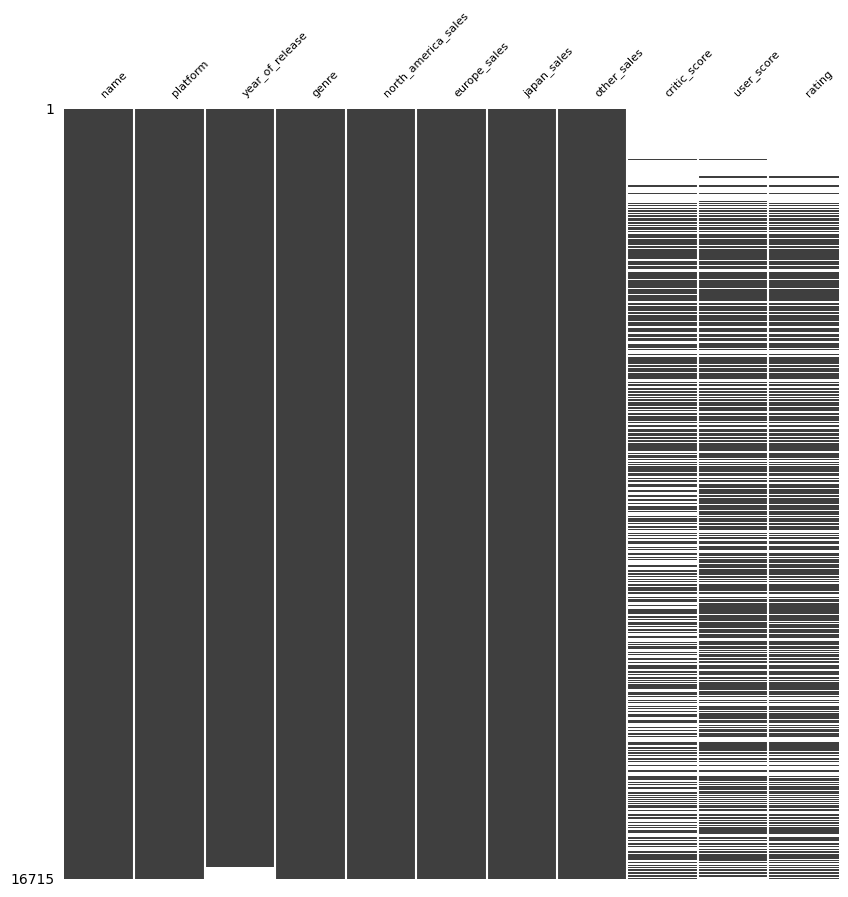

In [10]:
missingno.matrix(data.sort_values(by='year_of_release'),
                 figsize=(10, 10), fontsize=8, sparkline=False)

Тут все что белое- пропуски, серое - значение.   
Видно, что пропуски в столбцах с оценками и рейтингом есть сразу в них всех, особенно картина пропусков схожа между столбцами с оценками пользоваелей и рейтингом ESRB.  
Причина пропусков, скорее всего, в том что данные по оценками и  рейнгу нашлись не все, особенно это демонстрируют пропуски в начале этих 3х столбцов - организация ESRB была основана в 1994 году, а значит игры до 1994 года не могли получить ни рейтинг, ни оценки(пояснение ниже).

Пояснение

In [11]:
(data
 .groupby(by='year_of_release',
             as_index=False)
 [['critic_score',
   'user_score',
   'rating']]
 .count()
 .head(20)
 .style
 .highlight_min(color='royalblue',
                subset=['critic_score',
                        'user_score',
                        'rating'])
 .format(precision=0)
 )

,year_of_release,critic_score,user_score,rating
0,1980,0,0,0
1,1981,0,0,0
2,1982,0,0,0
3,1983,0,0,0
4,1984,0,0,0
5,1985,1,1,1
6,1986,0,0,0
7,1987,0,0,0
8,1988,1,1,1
9,1989,0,0,0


Для приведения данных в столбце user_score ознакомимся с его содержимым.

In [12]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

значение tbd  можно интерпретировать как "оценка еще не определена" , а значит его можно заменить на пропуск, а значения приведем к типу float.

In [13]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

# проверим
info_dataframe_new = InfoDataframe(data)
print('До обработки tbd')
display(info_dataframe.table_missing)

print('После обработки tbd')
display(info_dataframe_new.table_missing)

До обработки tbd


,missing,count_missing,type
platform,0.00 %,0,object
japan_sales,0.00 %,0,float64
europe_sales,0.00 %,0,float64
north_america_sales,0.00 %,0,float64
other_sales,0.00 %,0,float64
name,0.01 %,2,object
genre,0.01 %,2,object
year_of_release,1.61 %,269,float64
user_score,40.09 %,6701,object
rating,40.48 %,6766,object


После обработки tbd


,missing,count_missing,type
platform,0.00 %,0,object
japan_sales,0.00 %,0,float64
europe_sales,0.00 %,0,float64
north_america_sales,0.00 %,0,float64
other_sales,0.00 %,0,float64
name,0.01 %,2,object
genre,0.01 %,2,object
year_of_release,1.61 %,269,float64
rating,40.48 %,6766,object
critic_score,51.32 %,8578,float64


tbd больше нет в столбце и тип данных стал верным

Посчитаем суммарные продажи во всех регионах и сохраним в новом столбце

In [14]:
data['global_sales'] = data[['north_america_sales',
                             'europe_sales', 'japan_sales', 'other_sales']].sum(axis=1)

data.head().T

,0,1,2,3,4
name,Wii Sports,Super Mario Bros.,Mario Kart Wii,Wii Sports Resort,Pokemon Red/Pokemon Blue
platform,Wii,NES,Wii,Wii,GB
year_of_release,2006.0,1985.0,2008.0,2009.0,1996.0
genre,Sports,Platform,Racing,Sports,Role-Playing
north_america_sales,41.36,29.08,15.68,15.61,11.27
europe_sales,28.96,3.58,12.76,10.93,8.89
japan_sales,3.77,6.81,3.79,3.28,10.22
other_sales,8.45,0.77,3.29,2.95,1.0
critic_score,76.0,NaN,82.0,80.0,NaN
user_score,8.0,NaN,8.3,8.0,NaN


Глобальные продажи помогут взглянуть на продажи в целом, и пригодятся для исследовательского анализа.

## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные года

In [15]:
game_year_count = data['year_of_release'].value_counts()

In [16]:
fig = px.bar(game_year_count).update_layout(
    title='Количество игр выпускаемых в разные года',

    xaxis=dict(title='год выпуска'),

    yaxis=dict(title='количество'),

    showlegend=False)
iplot(fig)

Построим по тепловлй карте как менялись продажи платформ во времени но рассмотрение возьмем с 1993 года.

In [17]:
bound_year = 1993

sort_data = data.query(
    'year_of_release>@bound_year').sort_values('year_of_release')
fig = px.density_heatmap(sort_data, x='year_of_release', y='platform', z='global_sales',
                         text_auto=True,
                         labels={'year_of_release': 'год релиза',
                                 'platform': 'платформы', 'global_sales': 'глобальные продажи'},
                         title=f'Суммарные продажи платформ c {bound_year} по 2016 гг',
                         height=800)
iplot(fig)

Возьмем данные за 4 года то есть с 2013 по 2016 включительно

In [18]:
bound_year = 2013
actuality_data = data.query('year_of_release>@bound_year')

Отберем несколько платформ с наибольшими суммарными продажами и построим распределение по годаам.  
Для наглядности построим график.

In [19]:
glob_platform = (actuality_data
                 .groupby('platform', as_index=False)
                 ['global_sales']
                 .sum()
                 .sort_values(ascending=False, by='global_sales'))

In [20]:
fig = px.bar(glob_platform,
             x='platform',
             y='global_sales',
             title=f'Суммарные продажи игровых платформ c {bound_year} по 2016 гг',
             labels={'platform': 'платформа', 'global_sales': 'суммарные продажи, млн шт'})
iplot(fig)

Видно что лидерами по продажам платформы: PS4(самая популярная), XOne - более 130 млн продаж.
Отберем эти платформы.

In [21]:
major_platform = glob_platform['platform'][glob_platform['global_sales'] > 130]
# проверим
major_platform

3     PS4
9    XOne
Name: platform, dtype: object

Построим график суммарных продаж игровых платформ по годам 

In [22]:
ultra_pop_platform = actuality_data.query('platform in @major_platform')

d = ultra_pop_platform.groupby(['platform', 'year_of_release'], as_index=False)[
    'global_sales'].sum()

In [23]:
fig = px.line(d,
              x='year_of_release',
              y='global_sales',

              color='platform',
              labels={'platform': 'платформа',
                      'year_of_release': 'год',
                      'global_sales': 'глобальные продажи, млн шт'},
              title='Суммарные продажи платформ с 2013 по 2016 гг',
              width=800)
fig.update_traces(line_width=4)
iplot(fig)

Построим ящик с усами по глобальным продажам игр в разбивке по платформам.

In [24]:
fig = px.box(data_frame=ultra_pop_platform,
             y='platform',
             x='global_sales',
             labels={'platform': 'платформа',
                     'year_of_release': 'год',
                     'global_sales': 'глобальные продажи, млн шт'},

             title='Глобальные продажи игр для платформ',

             width=800)
iplot(fig)

Посмотрим, как влияют на продажи внутри одной популярной платформы PS4 отзывы пользователей и критиков. Построим диаграмму рассеяния

In [25]:
one_pop_platform = actuality_data.query('platform=="PS4"')

In [26]:

fig = px.scatter(data_frame=one_pop_platform,
                 x='user_score',
                 y='global_sales',
                 )

fig.update_layout(title=dict(text=f'Влияние оценок пользователей на продажи игр для платформы PS4', font_size=14),
                  xaxis=dict(title='оценка', range=(-1, 11)),
                  yaxis=dict(title='продано игр, млн шт'), width=600)
iplot(fig)

In [27]:
print(
    f"Коэффициент корреляции {one_pop_platform['user_score'].corr(one_pop_platform['global_sales'])}")

Коэффициент корреляции -0.040131589472697356


Оценки пользователей  не влияют на продажи игр

In [28]:

fig = px.scatter(data_frame=one_pop_platform,
                 x='critic_score',
                 y='global_sales')

fig.update_layout(title=dict(text='Влияние оценок критиков на продажи игр для платформы PS4', font_size=14),
                  xaxis=dict(title='оценка', range=(-1, 110)),
                  yaxis=dict(title='продано игр, млн шт'),
                  width=600)
iplot(fig)

In [29]:
print(
    f"Коэффициент корреляции {one_pop_platform['critic_score'].corr(one_pop_platform['global_sales'])}")

Коэффициент корреляции 0.40266141068104083


Оценки критиков  слабо влияют на продажи игр

Посмотрим общее распределение игр по жанрам, но рассмотрим медианные значения суммарных продаж.

In [30]:
game_genre = (actuality_data
              .groupby('genre')['global_sales']
              .median()
              .sort_values(ascending=False))

In [31]:
fig = px.bar(data_frame=game_genre.sort_values(),
             orientation='h')

fig.update_layout(title=dict(text='Распреление игр по жанрам'),
                  xaxis=dict(title='продано игр, млн'),
                  yaxis=dict(title='игровые жанры'),
                  width=600,
                  showlegend=False)
iplot(fig)

Достаточно популярный жанр игр это  `shooter`. В основном из-за того что жанр интересен игрокам из-за необходимой концентрации внимания, координации рук и глаз, тактических испытаний и точности. А происходящее может разворачиваться стремительно и неожиданно.

## Составление портрета пользователя каждого региона (С.Америка, Европа, Япония)

Найдем топ-5 игровых платформ в Северной Америке, Европе и Японии

In [32]:
for country, region in zip(['north_america_sales', 'europe_sales', 'japan_sales'],
                           ['Северная Америка', 'Европа', 'Япония']):

    print(f'\nТоп-5 платформ: {region}\n{"-"*15}')
    print(actuality_data
          .groupby('platform')[country]
          .sum()
          .sort_values(ascending=False)
          .head())


Топ-5 платформ: Северная Америка
---------------
platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
Name: north_america_sales, dtype: float64

Топ-5 платформ: Европа
---------------
platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
Name: europe_sales, dtype: float64

Топ-5 платформ: Япония
---------------
platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
Name: japan_sales, dtype: float64


Как видим, популярными платформами сразу в 3x регионах являются платформа PlayStation 2х поколений, особенно PS4.   
Следует отметить, что в Америке и Европе одни и теже платформы популярны.  
У Японии свои вкусы.



Найдем топ-5 игровых жанров в Северной Америке, Европе и Японии

In [33]:
for country, region in zip(['north_america_sales', 'europe_sales', 'japan_sales'],
                           ['Северная Америка', 'Европа', 'Япония']):

    print(f'\nТоп-5 игровых жанров: {region}\n{"-"*25}')

    print(actuality_data
          .groupby('genre')[country]
          .sum()
          .sort_values(ascending=False)
          .head())


Топ-5 игровых жанров: Северная Америка
-------------------------
genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Name: north_america_sales, dtype: float64

Топ-5 игровых жанров: Европа
-------------------------
genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Name: europe_sales, dtype: float64

Топ-5 игровых жанров: Япония
-------------------------
genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Name: japan_sales, dtype: float64


Пожалуй самыми популярными жанрами игр можно назвать Action,Shooter, Sports, - распространен в Америке, Европе.  
Япония снова отличилась - преобладает Role-Playing, Action .


Расммотрим суммарные продажи в регионах от рейтинга ESRB

Для простого восприятия рейтинга ESRB сделаем его удобочитаемым и запишем в новый столбец 

In [34]:
def translate_rating(arg):
    if arg == 'E' or arg == 'K-A':
        return '6+'
    elif arg == 'EC':
        return '3+'
    elif arg == 'E10+':
        return '10+'
    elif arg == 'T':
        return '13+'
    elif arg == 'M':
        return '17+'
    elif arg == 'AO':
        return '18+'
    elif arg == 'RP':
        return 'ожидается'

In [35]:
actuality_data['translate_rating'] = (actuality_data['rating']
                                      .apply(translate_rating))

In [36]:
pop_rating = (actuality_data
              .groupby('translate_rating',
                       as_index=False)[
                           ['north_america_sales',
                            'europe_sales',
                            'japan_sales']
              ]
              .sum())


pop_rating.style.background_gradient(cmap='viridis').format(precision=2)

,translate_rating,north_america_sales,europe_sales,japan_sales
0,10+,33.23,26.16,4.46
1,13+,38.95,34.07,14.78
2,17+,96.42,93.44,8.01
3,6+,50.74,58.06,8.94


При построении графика разделим данные по регионам

In [37]:
fig = px.bar(pop_rating,
             x='translate_rating',
             y=['north_america_sales',
                'europe_sales',
                'japan_sales'],

             barmode='group',
             facet_col='variable',
             labels={'translate_rating': 'возрастная категория',
                     'variable': 'регион'})

fig.update_layout(title='Количество проданных игр в регионах от рейтинга ESRB ',
                  yaxis=dict(title='продано игр, млн'))
iplot(fig)

Делаем следующий вывод:  
В Америке и Европе схожи продажи - 1е место занпимают продажи игр для лиц от 17 лет, 2е место - игры для лиц от 6 лет.   
Япония снова отличилась - 1е место - продажи игр для лиц от 13 лет, 2е место делят продажи от 6 и от 17 лет.  




## Проверка гипотез

Проверим гипотезы  
Нулевая гипотеза -  средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
Альтернативная - средние пользовательские рейтинги Xbox One и PC разные.

In [38]:
alpha = 0.05

user_score_xbox_one = (actuality_data[
    actuality_data['platform'] == 'XOne']
    ['user_score']
    .dropna()
)

user_score_pc = (actuality_data[
    actuality_data['platform'] == 'PC']
    ['user_score']
    .dropna()
)

print('Средняя пользовательская оценка для платформ')
print(f'Xbox One: {user_score_xbox_one.mean()}')
print(f'PC: {user_score_pc.mean()}\n')

results = st.ttest_ind(user_score_xbox_one, user_score_pc)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Средняя пользовательская оценка для платформ
Xbox One: 6.594545454545456
PC: 6.298360655737705

p-value: 0.10450507919348416
Не отвергаем нулевую гипотезу


Итак, выходит,что пользовательские рейтинги платформ Xbox One и PC одинаковые.

Проверим гипотезы  
Нулевая гипотеза -  средние пользовательские рейтинги жанров Action и Sports одинаковые.  
Альтернативная - средние пользовательские рейтинги жанров Action и Sports разные.

In [39]:
alpha = 0.05

user_score_action = (actuality_data[
    actuality_data['genre'] == 'Action']
    ['user_score']
    .dropna()
)

user_score_sports = (actuality_data[
    actuality_data['genre'] == 'Sports']
    ['user_score']
    .dropna()
)

print('Средняя пользовательская оценка для жанров')
print(f'Action: {user_score_action.mean()}')
print(f'Sports: {user_score_sports.mean()}\n')

results = st.ttest_ind(user_score_xbox_one, user_score_pc)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Средняя пользовательская оценка для жанров
Action: 6.760606060606061
Sports: 5.2251968503937

p-value: 0.10450507919348416
Не отвергаем нулевую гипотезу


Тут средние пользовательские оценки жанров Action и Sports тоже одинаковые.

## Общий вывод

Переименовав столбцы, исследовав аббревиатуру tbd в столбце с оценками пользователей и обработав ее, рассмотрев количество пропусков и проверив на наличие дубликатов,  
 исследовали исторические данные о продажах компьютерных игр, оценки пользователей и экспертов, жанры и игровые платформы.    
Рассмотрев количество проданных игр в разные года, определили, что использовать данные лучше с 1993 года.   
По тепловой карте выяснили, что на момент 2016 года, продажи следующих платформ убывают:  
XOne  
PS4   
WiiU   
PSV   
3DS   
PS3
Wii    
X360       
PC.
Затем выяснили, что прибыльными платформами являются PS4(самая прибыльная за взятый период) и XOne. Следовательно PS4 , появивщаяся в 2013 году, будет востребована в 2017 году изза игр, которые должны выпускаться для нее.Такое же наблюдается и у платформы XOne.  
 И еще добавим, что платформа PC (персонал.компьютеры) хотя и не имеет высоких продаж как игровые платформы, но игры востребованы для нее каждый год, а значит и в 2017 году игры для нее будут продаваться.  

Исследовали зависимость оценок критиков и пользователей на глобальные продажи PS4 и пришли к выводу, что оценки критиков слабо влияют на продажи , в то время как оценки  пользователей почти не влияют.  
Определили популярные игровые жанры - Shooter.  
Создали портрет пользователей в C.Америке, Европе и Японии найдя топ-5 платформ и жанров игр.

В топ-5 платформ для Северной Америки вошли -   
PS4     
XOne    
X360   
3DS     
PS3       

Для Европы -   
PS4     
XOne     
PS3      
PC       
3DS      

Для Японии -   
3DS     
PS4     
PSV     
PS3     
WiiU    

В топ-5 жанров для Северной Америки вошли -  
Shooter         
Action          
Sports         
Role-Playing   
Misc            

Для Европы -   
Action          
Shooter         
Sports          
Role-Playing    
Racing          

Для Японии -  
Role-Playing    
Action          
Fighting        
Misc            
Shooter          
 
Затем исследовали продажи игр в C.Америке, Европе, Японии от рейтинга ESRB.
В Америке и Европе схожи продажи - 1е место занпимают продажи игр для лиц от 17 лет, 2е место - игры для лиц от 6 лет.   
Япония снова отличилась - 1е место - продажи игр для лиц от 13 лет, 2е место делят продажи от 6 и от 17 лет. 

Затем проверили гипотезы о равенстве средних пользовательских рейтингов платформ Xbox One и PC и и равенстве средних пользовательских оценок жанров Action и Sports. Пришли к выводу что средние пользовательские оценки платформ одинаковые, и средние пользовательские оценки жанров тоже одинаковые.

Итак, мы пришли к факторам, определяющим успешность игры:
 - возрастная категория. В основном больше продаж игр для лиц от 17 лет . А еще популярны игры для лиц от 6 и от 13 лет.
 - жанр. Популярным оказался Shooter , который требует от игрока внимательности, реакции, тактики, а развитие действий в игре  может быть непредсказуемо - из-за этого он интересен игрокам.
 - платформа. Наличие возможности подключения нескольких игроков - жирный плюс - в компании играть интереснее чем в одиночку.   
 
А в 2017 игроки продолжать играть на PS4, XOne и даже на PC.


